# Balanced Clustering

This is a document using a simple (greedy) algorithm for balancing clusters.

## Helper functions

There are a number of helper functions here for the main algo. Most are self-explanatory, but the less intuitive ones have docstrings. This is not the focus of the notebook.

In [1]:
def argmin(D):
    '''
    Argmin for a dictionary, D.
    '''
    return min(D, key=D.get)

In [2]:
def get_centroid(cluster_elements):
    return cluster_elements.mean(axis=0)

In [3]:
def get_centroids(clusters_dict):
    return {k : get_centroid(clusters_dict[k]) for k in clusters_dict.keys()}

In [4]:
def get_group_num_elements(group_name, clusters_dict):
    return clusters_dict[group_name].shape[0]

In [5]:
def get_all_group_sizes(clusters_dict):
    return {group_name : get_group_num_elements(group_name, clusters_dict) for group_name in clusters_dict.keys()}

In [6]:
def get_group_with_fewest_elements(clusters_dict):
    '''
    Given a dictionary, mapping from group name
    to a numpy array of group element coordinates,
    return the name (AKA key) of the group that has
    the fewest number of elements. Ties are not handled
    arbitrarily.
    '''
    group_names = list(clusters_dict.keys()) # create indexable list
    num_elements_list = [ get_group_num_elements(group_name, clusters_dict) for group_name in group_names ] # find number of elements for each key
    index_of_min = np.argmin(num_elements_list) # find index of min for the key
    return group_names[index_of_min] # return the key at the index where the min occurred

In [7]:
def distance_metric(a_coords, b_coords):
    '''
    This is flexible, but right now it's Euclidean
    distance. It could alternatively be absolute distance,
    or absolute distance cubed, or whatever.'''
    difference_array = a_coords - b_coords
    return np.linalg.norm(difference_array)

In [8]:
from math import floor
def get_smaller_than_average_cluster_names(cluster_dict):
    '''
    Returns names of clusters that need to increase their
    number of elements in order to balance the clusters
    over all. This means any cluster with fewer elements
    than the floor of the average will be returned.
    '''
    total_num_elements = sum([get_group_num_elements(group_name, cluster_dict) for group_name in cluster_dict.keys()])
    avg_group_size = total_num_elements / len(cluster_dict.keys())
    group_sizes = get_all_group_sizes(cluster_dict)
    smaller_than_avg_cluster_names = []
    for group_name in cluster_dict.keys():
        if ( get_group_num_elements(group_name, cluster_dict) <= floor(avg_group_size) ):
            smaller_than_avg_cluster_names += [group_name]
    return smaller_than_avg_cluster_names
    

In [9]:
def dictionary_check_equal(d1, d2):
    '''
    Checks whether two cluster dictionaries share
    the exact same elements.
    '''
    if d1.keys() != d2.keys(): return False
    num_equal = sum([1 if(np.array_equal(d1[k], d2[k])) else 0 for k in d1.keys()])
    return True if num_equal == len(d1.keys()) else False

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def plot_clusters(cluster_dict):
    '''
    The gist of this is to create a
    dataframe with columns being
    the x, y, and group name, and
    then plotting this in seaborn
    with the hue being the group name.
    '''
    def get_total_num_elements(cluster_dict):
        '''
        Just finds how many elements there
        are total in the cluster_dict (not
        how many numbers, but how many
        elements; an element may have
        multiple dimensions)'''
        total = 0
        for group_name in cluster_dict.keys():
            total += get_group_num_elements(group_name, cluster_dict)
        return total
    
    num_elements = get_total_num_elements(cluster_dict)
    all_elements = [ [0 for j in range(3)] for i in range(num_elements) ]
    row_counter = 0
    for group_name in cluster_dict.keys():
        cluster = cluster_dict[group_name]
        for element in cluster:
            all_elements[row_counter] = [group_name] + element.tolist()
            row_counter += 1
    all_elements_df = pd.DataFrame(all_elements, columns=['group_name', 'x', 'y'])
#     print(all_elements_df)
    sns.scatterplot(x='x', y='y', hue='group_name', data=all_elements_df)
    plt.show()

## Data

In order for this make sense, we will generate a random field of data that occupies four quadrants in 2D space. Although this approach should technically generalize to n-dimensional space. Here, we will generate some arbitrary clusters for example. However, these clusters could come from any clustering algorithm; in the original write up, I imagined that they may originate from k-means, but this is very versatile.

In [11]:
import numpy as np
def make_cluster(approx_centroid, noise_max, num_elements):
    '''
    Generates a cluster-ish area around the
    approx_centroid coordinates.
    
    Returns an 
    '''
#     assert type(approx_centroid) == type(['is', 'a', 'list'])
    cluster = []
    for i in range(num_elements):
        noise = np.random.uniform(low=-noise_max, high=noise_max, size=len(approx_centroid))
        coordinates = np.array(approx_centroid) + noise
        cluster += [coordinates]
    return np.array(cluster)

In [15]:
approx_centroids = [[0, 0], [10, 0], [0, 10], [10, 10]]
clusters = {
    'A' : make_cluster([0, 0], 2, 100), # based around (0, 0)
    'B' : make_cluster([10, 0], 2, 120), # based around (10, 0)
    'C' : make_cluster([0, 10], 2, 85), # based around (0, 10)
    'D' : make_cluster([10, 10], 2, 110) # based around (10, 10)
}

## Important Methods

In [16]:
def get_distances_from_small_group_centroid(cluster_dict, small_group_name):
    '''
    Goes and looks at all specified groups in a given
    cluster dictionary. It reports the distance from
    each individual point to the reference element.
    
    cluster_dict: a mapping from the name of each cluster to a numpy array of element
    small_group_centroid: 1 dimensional numpy array of numbers 
    small_group_num_elements: the number of elements in the smallest group
    return: 
        dictionary {
            distance : dictionary{
            'group_name': <string group name>, 
            'element': <np.array element values>
            } 
        }
        
    '''
    
    other_group_names = set(cluster_dict.keys())
    other_group_names.remove(small_group_name)
    
    centroids = get_centroids(cluster_dict)
    small_group_centroid = centroids[small_group_name]
    
    small_group_num_elements = get_group_num_elements(small_group_name, cluster_dict)
    
    distances_from_small_group_centroid = {} 
    for group_name in other_group_names:
        group_num_elements = get_group_num_elements(group_name, cluster_dict)
        # The rule is that we can only take elements from a cluster that currently
        # has at least 2 more elements than the cluster with the least number of elements
        if (group_num_elements - small_group_num_elements) >= 2:
            group_elements = cluster_dict[group_name]
            # This could be sped up with list comprehension, but not implementing at this stage
            # so as to preserve clarity
            for element in group_elements:
                distance_to_small_group_centroid = distance_metric(small_group_centroid, element)
                distances_from_small_group_centroid[distance_to_small_group_centroid] = {
                    'group_name':group_name, 'element':element
                }
    return distances_from_small_group_centroid


In [17]:
def move_element(cluster_dict_inp, small_group_name, large_group_name, moving_element, verbose):
    cluster_dict = cluster_dict_inp.copy()
    
    # Get the index of the row that should be taken out of the old cluster
    index_of_deletion = np.argwhere(cluster_dict[large_group_name]==moving_element)[0, 0]
    # Move row out of old cluster
    cluster_dict[large_group_name] = np.delete(cluster_dict[large_group_name], index_of_deletion, axis=0)
    # Move row to new, small cluster
    cluster_dict[small_group_name] = np.append( cluster_dict[small_group_name], [moving_element], axis=0 )

    if verbose.lower() in ('text', 'all'): print(f'Moving {moving_element} from cluster '
                                                     + f'{large_group_name}'
                                                      + f' to cluster {small_group_name}')
    return cluster_dict


In [18]:
def move_element_to_smallest(cluster_dict_inp, verbose):
    '''
    Description:
        This method takes in clusters and then moves an element from a list with more
        elements to the list with the fewest elements. Iterating on this stepper 
        guarantees making balanced clusters (i.e. it's impossible to get stuck in an
        infinite loop of moving elements in circles).
    
    Parameters:
        cluster_dict_inp: a dictionary that maps from cluster names to numpy arrays;
                            the dimension of the array is the dimension of a sample
        verbose: string, specifying the mode of verbosity; if it is 'all', then
                 both text and plots will be displayed; if 'plot', then only plots
                 will be displayed, not text; if 'text', then only text will be 
                 displayed, not plots.
    Return:
        Returns a cluster dictionary with one of the elements moved from a larger group to the smallest
        group.
    '''
    cluster_dict = cluster_dict_inp.copy()
    
    if verbose.lower() in ('text', 'all'): print(f'Group sizes: {get_all_group_sizes(cluster_dict)}')
    small_group_name = get_group_with_fewest_elements(cluster_dict)

    # See how far the small group is from elements in larger groups
    distances_from_small_group_centroid = get_distances_from_small_group_centroid(cluster_dict, small_group_name)
    
    if not distances_from_small_group_centroid:
        # If the method returned an empty dictionary of possible distances,
        # this implies that there are no further changes to make, and thus the
        # function is finished running.
        return cluster_dict
    else:
        # Now find the smallest centroid and move it from its current cluster to the smallest cluster
        distances_from_small_group_centroid_list = distances_from_small_group_centroid.keys()
        shortest_dist_from_small_centroid = min(distances_from_small_group_centroid_list)
        moving_element_information = distances_from_small_group_centroid[shortest_dist_from_small_centroid]

        moving_element_previous_group_name = moving_element_information['group_name']
        moving_element = moving_element_information['element']

        cluster_dict = move_element(cluster_dict, small_group_name, moving_element_previous_group_name,
                                   moving_element, verbose)
        return cluster_dict

In [19]:
def get_smallest_dist_move(distance_dict):
    '''
    input: dictionary{ key = <small group name>, 
                      value = <dictionary {key = <distance>,
                                           value = dictionary { key = 'group_name' : value = <group name>
                                                                key = 'element' : value = <numpy array of element value>                                                           
                                                              }
                                           }
                     }
    returns: tuple of (<small group name>, <large group name>, <element>)
    '''
    # Getting the smallest possible move
    small_group_names = distance_dict.keys()
    
    small_group_name_to_smallest_distance = {}
    for small_group_name in small_group_names:
        if distance_dict[small_group_name]:
            small_group_name_to_smallest_distance[small_group_name] = min(
                distance_dict[small_group_name].keys())
    
    if small_group_name_to_smallest_distance.keys():                                                                  
        # Getting name of small group that will receive element (optimal group to receive element)
        smallest_move_small_group_name = argmin(small_group_name_to_smallest_distance)

        # Getting information of the group that the element is getting moved from
        smallest_move_dist = small_group_name_to_smallest_distance[smallest_move_small_group_name]
        element_to_move_info = distance_dict[smallest_move_small_group_name][smallest_move_dist]
        element_previous_group_name = element_to_move_info['group_name']
        element = element_to_move_info['element']
        return (smallest_move_small_group_name, element_previous_group_name, element)
    else:
        return (None, None, None)
        

In [20]:
def move_element_to_optimal_smaller_cluster(cluster_dict_inp, verbose):
    '''
    Description:
        Moves an element from to one of the clusters with fewer elements than average, by
        taking an element from one of the clusters with at least two more elements. Very
        similar to move_element_to_smallest(), but instead this method does not have
        to move an element to the smallest cluster; it just needs to move an element to
        a cluster that has fewer elements than average. This is the minimal constraint
        for making monotonic progress toward balanced classes (that I've found, at least).
    Parameters:
        cluster_dict_inp:  a dictionary that maps from cluster names to numpy arrays;
                            the dimension of the arrays is the dimension of a sample
        verbose: string specifying the mode of verbosity; if it is 'all', then
                 both text and plots will be displayed; if 'plot', then only plots
                 will be displayed, not text; if 'text', then only text will be 
                 displayed, not plots.
    Return:
        Returns a new cluster dictionary.
    '''
    
    cluster_dict = cluster_dict_inp.copy()

    if verbose.lower() in ('text', 'all'): print(f'Group sizes: {get_all_group_sizes(cluster_dict)}')
    
    # Get names of clusters that could receive more elements
    small_group_names = get_smaller_than_average_cluster_names(cluster_dict)
    if verbose.lower() in ('all', 'text'): print(f'small_group_names: {small_group_names}')
    small_group_name_to_moving_distance_dictionary = {group_name : 
                                                      get_distances_from_small_group_centroid(
                                                          cluster_dict, group_name)
                                                      for group_name in small_group_names}
    # Get the information of the move that has the smallest distance metric
    small_group_name, large_group_name, moving_element = get_smallest_dist_move(
        small_group_name_to_moving_distance_dictionary)

    if ((small_group_name != None) and (large_group_name != None) and (moving_element.size != 0)):
        cluster_dict = move_element(cluster_dict, small_group_name, large_group_name, moving_element, verbose)
    
    return cluster_dict    
    

In [21]:
def balance_clusters(cluster_dict_inp, element_mover, max_iterations=100, verbose='text'):
    '''
    Description:
        This method takes in clusters and then balances all of the clusters so
        that they have the same number of elements (or are within one of each other).
    
    Parameters:
        cluster_dict_inp: a dictionary that maps from cluster names to numpy arrays;
                            the dimension of the array is the dimension of a sample
        element_mover: a function that takes in the parameters below and then edits
                       the cluster dictionary taken as input
        max_iterations: the maximum number of iterations before the algorithm stops;
                        this is a fail-safe from indefinite looping (although this
                        should not be an issue if the code is correct)
        verbose: string, specifying the mode of verbosity; if it is 'all', then
                 both text and plots will be displayed; if 'plot', then only plots
                 will be displayed, not text; if 'text', then only text will be 
                 displayed, not plots.
    Return:
        a dictionary of the exact same form as cluster_dict_inp, except with balanced
        clusters
    '''
    cluster_dict = cluster_dict_inp.copy() # copy, so as not to edit original
    
    counter = 0 
    while counter < max_iterations:
        cluster_dict_old = cluster_dict.copy()
        cluster_dict = element_mover(cluster_dict, verbose)
        if dictionary_check_equal(cluster_dict_old, cluster_dict): 
            if verbose.lower() in ('text', 'all'): print('There are no more small groups.')
            return cluster_dict # no changes were made to cluster dictionary, so return it
        else:
            # Plotting only works for 2 dimensional data. This checks if the data is 2D
            is2d = len(cluster_dict[list(cluster_dict.keys())[0]][0]) == 2
            if verbose.lower() in ('plot', 'all') and is2d: plot_clusters(cluster_dict)
            counter += 1
    return cluster_dict
            
            

In [22]:
from time import time
start = time()
balanced_clusters_move_to_smallest = balance_clusters(clusters,
                                                      move_element_to_smallest, 
                                                      max_iterations=1000,
                                                      verbose='none')
end = time()
print(f"Finished simpler way in {end-start} seconds.")

Finished simpler way in 0.07872700691223145 seconds.


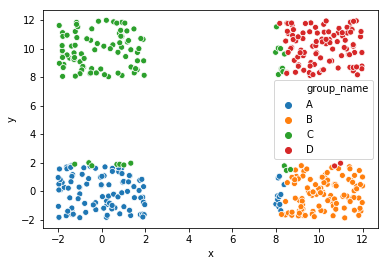

In [23]:
plot_clusters(balanced_clusters_move_to_smallest)

In [24]:
start = time()
balanced_clusters_move_to_optimal = balance_clusters(clusters, move_element_to_optimal_smaller_cluster, verbose='none')
end = time()
print(f"Finished more complicated way in {end-start} seconds.")


Finished more complicated way in 0.1609642505645752 seconds.


In [25]:
get_all_group_sizes(balanced_clusters_move_to_optimal)

{'A': 103, 'B': 104, 'C': 104, 'D': 104}

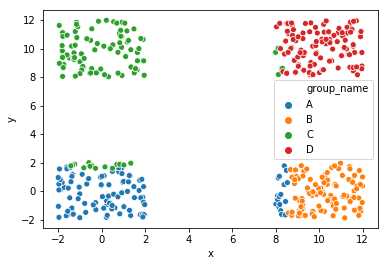

In [26]:
plot_clusters(balanced_clusters_move_to_optimal)